In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# portfolio optimization
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [2]:
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

Пропишем пути до папок с данными и изображениями.

In [4]:
current_dir = Path.cwd()
print(f"Текущая директория: {current_dir}")
data_dir = Path(*current_dir.parts[0:-1])/'data'
image_dir = Path(*current_dir.parts[0:-1])/'images'
print(f"Директория для хранения данных: {data_dir}")
print(f"Директория для хранения изображений: {image_dir}")

Текущая директория: C:\Users\Vladimir\Desktop\FMFI_1\Магистерские курсы\Управление портфелем\portfolio_HW\scripts
Директория для хранения данных: C:\Users\Vladimir\Desktop\FMFI_1\Магистерские курсы\Управление портфелем\portfolio_HW\data
Директория для хранения изображений: C:\Users\Vladimir\Desktop\FMFI_1\Магистерские курсы\Управление портфелем\portfolio_HW\images


### Оглавление

1. [Отбор эмитентов для портфеля](#imoex10)
2. [Рассчитать матрицы доходностей и ковариационные матрицы для отобранных акций на различные даты](#covmat)
3. Построить границу эффективных портфелей при условии, что короткие продажи разрешены и не имеют ограничений.
4.	Построить границу эффективных портфелей при условии, что короткие продажи разрешены, но доходы от короткой продажи каждой акции не должны превышать 25% от собственных средств (капитала) инвестора.
5.	Построить границу эффективных портфелей при условии, что короткие продажи запрещены.
6.	Построить границу эффективных портфелей при условии, что в каждую из акций должно быть вложено не менее 2% капитала.
7.	Проанализировать динамику изменения границы эффективных портфелей.
8.	[Выбрать индекс для расчёта исторических и скорректированных $\beta$. Привести обоснование выбора.](#choosebeta)
9.	[Рассчитать ковариационную матрицу для отобранных акций на основе исторических $\beta$ (historical betas), которые оцениваются согласно рыночной модели (market model).](#betacovmat)
10.	[Построить границу эффективных портфелей на основе полученной в п. 8 ковариационной матрицы и проанализировать динамику её изменения.](#betacovmat_results)
11.	Рассчитать ковариационную матрицу для отобранных акций на основе скорректированных β (adjusted betas).
12.	Построить границу эффективных портфелей на основе полученной в п. 10 ковариационной матрицы и проанализировать динамику её изменения.
13.	Сравнить границы эффективных портфелей, рассчитанные различными способами. Привести экономическую интерпретацию полученных результатов.


Этот ноутбук содержит в себе результаты выполнения задания по курсу "Управление портфелем".

### Поиск всех эмитентов, которые когда - либо входили в индекс ММВБ-10. Отбор эмитентов для портфеля и загрузка данных.<a class="anchor" id="imoex10"></a>

* Поскольку в индекс ММВБ-10 регулярно отбираются 10 "лучших" по ряду параметров акций, торгующихся на ММВБ, будем отталкиваться от компаний, вошедших в индекс, при формировании вселенной для инвестирования.
[Данные о ребалансировках индекса и конкретных эмитентах можно скачать на сайте Мосбиржи в соответствующем разделе.](https://www.moex.com/ru/index/MOEX10/constituents/)

Посмотрим, что из себя представляет страница ребалансировок за какой-то год в Эксель-файле.

In [5]:
fpath = data_dir/'stock-index-base-moex10-210318.xlsx'
moex10 = pd.DataFrame(pd.read_excel(fpath, 
                                    engine='openpyxl', 
                                    sheet_name='2010'))
moex10.head()

,Year,Quarter,FirstDate,LastDate,SecID,P_0,K,NumDays,NumTrades,Turnover,NumParticipants
0,2010,1,2010-01-12,2010-04-01,FEES,0.320,3174.8349,65,418551,4.103957e+10,289
1,2010,1,2010-01-12,2010-04-01,GAZP,183.090,3174.8349,65,5426444,9.970023e+11,400
2,2010,1,2010-01-12,2010-04-01,GMKN,4245.020,3174.8349,65,1989564,2.547251e+11,315
3,2010,1,2010-01-12,2010-04-01,HYDR,1.138,3174.8349,65,480948,4.036241e+10,296
4,2010,1,2010-01-12,2010-04-01,LKOH,1694.000,3174.8349,65,2377757,2.695565e+11,350


Мы поняли, что нас интересует SecID. Теперь надо собрать все тикеры со всех листов, начиная с 2010 года.

In [6]:
from functools import reduce

years = [str(x) for x in range(2010, 2022)]
tickers = []

for year in years:
    tickers+=\
        pd.read_excel(fpath, 
                      sheet_name=year, 
                      usecols=['SecID']).values.ravel().tolist()

tickers = [ticker.strip() for ticker in tickers]
list(set(tickers))

['SNGSP',
 'AFLT',
 'SBERP03',
 'TATN',
 'GMKN',
 'HYDR',
 'FEES',
 'SBER',
 'MAGN',
 'RTKM',
 'SNGS',
 'YNDX',
 'MTSS',
 'POLY',
 'MOEX',
 'ALRS',
 'NVTK',
 'VTBR',
 'GAZP',
 'MTLR',
 'ROSN',
 'URKA',
 'SBERP',
 'TRNFP',
 'LKOH',
 'SBER03',
 'PLZL',
 'NLMK',
 'MGNT',
 'AFKS',
 'CHMF']

Единственное, что смущает - это какой-то непонятный SBER03. Выкинем его из списка.

In [7]:
tickers = list(filter(lambda x: x not in ['SBER03', 'SBERP03'], tickers))
unique_tickers = list(set(tickers))

<Figure size 1296x360 with 0 Axes>

C:\Users\Vladimir\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

Text(0.5, 1.0, 'Частота появления эмитента в индексе ММВБ-10')

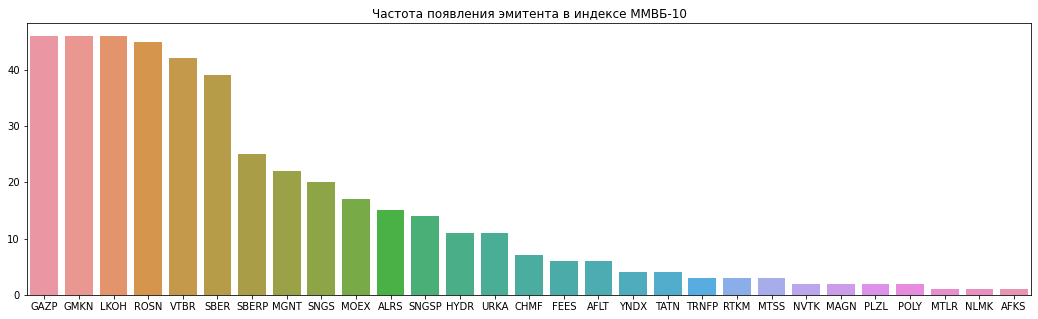

In [8]:
from collections import Counter

countdata = Counter(tickers)
countdata = dict(sorted(countdata.items(), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(18, 5));
sns.barplot(list(countdata.keys()), list(countdata.values()));
plt.title('Частота появления эмитента в индексе ММВБ-10');

plt.savefig(image_dir/'Frequencies of MOEX10 constituents.jpg')

In [9]:
print(f'Всего в нашей выборке оказалось {len(set(tickers))} уникальных эмитентов')

Всего в нашей выборке оказалось 29 уникальных эмитентов


In [10]:
ticker_df = pd.DataFrame({'ticker': list(countdata.keys()),
                          'n_times': list(countdata.values())})
ticker_df.to_csv(data_dir/'imoex10.csv')

При желании, можно выкинуть примерно половину эмитентов - оставить всех, кто не менее 10 раз попадал в индекс, и посчитать портфель для такого "сокращённого состава". Но поскольку задание требует работать не менее чем с 30 эмитентами, придётся оставить всех.

Теперь получим котировки с 2010 по 2021 год с помощью нашего модуля `parser.py`. Он качает данные напрямую по API Мосбиржи - это позволяет надеяться, что цифры, которые мы получим, будут не совсем бессмысленными.

In [11]:
tickers = pd.read_csv(data_dir/'imoex10.csv', usecols=['ticker'])
tickers = tickers.ticker.values.ravel().tolist()

In [12]:
from moexparser import get_historical_data

df = get_historical_data(tickers,
                         start_date = '2010-01-01',
                         end_date = '2021-06-12')
df.head(5)

,GAZP,GMKN,LKOH,ROSN,VTBR,SBER,SBERP,MGNT,SNGS,MOEX,ALRS,SNGSP,HYDR,URKA,CHMF,FEES,AFLT,YNDX,TATN,TRNFP,RTKM,MTSS,NVTK,MAGN,PLZL,POLY,MTLR,NLMK,AFKS
TRADEDATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-06-09,144.40,7029,2025.0,240.36,0.04731,88.89,73.40,8949.0,26.942,65.66,40.800,27.48,0.7299,154.05,296.5,0.05968,58.84,1172.1,207.63,77050,87.69,297.55,405.93,6.835,511.6,314.79,49.7,49.42,44.448
2014-06-10,144.75,6900,2061.4,242.80,0.04700,88.99,73.33,9100.0,27.394,63.88,40.650,27.55,0.7088,157.18,293.4,0.05965,58.85,1170.0,211.00,77055,88.80,296.63,401.37,6.762,507.0,316.49,53.2,48.60,45.499
2014-06-11,146.40,6940,2097.9,249.66,0.04698,89.00,73.69,9070.0,27.559,65.65,40.300,28.15,0.7400,155.28,292.5,0.06015,58.74,1179.9,213.00,76510,88.06,301.20,400.70,6.770,512.8,314.59,51.4,48.33,45.300
2014-06-16,145.20,6649,2149.0,253.30,0.04643,84.85,69.45,8899.0,27.351,65.65,40.038,28.27,0.7320,153.08,285.4,0.05920,56.89,1165.0,219.25,75637,84.30,305.75,407.99,6.848,517.0,324.00,52.0,48.30,45.999
2014-06-17,144.77,6622,2130.0,251.59,0.04680,83.80,67.34,8799.0,27.792,66.30,39.878,28.20,0.7425,152.53,286.5,0.05808,55.06,1185.5,222.77,76065,83.22,301.00,408.34,6.857,513.1,311.50,55.5,48.39,46.100


Необходимо почистить выборку: посмотреть, сколько пропусков для каждого из эмитентов, принять решение, выбрасываем мы его или нет.

<AxesSubplot:title={'center':'Доля пропусков в ценах акций, %'}>

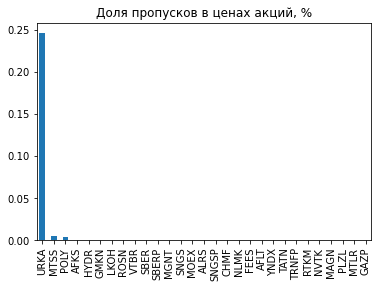

In [14]:
nan_df = {name:round(df[name].isna().sum()/df.shape[0], 3) for name in df.columns}
pd.Series(nan_df).sort_values(ascending=False).plot(kind='bar', title='Доля пропусков в ценах акций, %');

URKA - неликвидный эмитент, его мы можем удалить с чистой совестью. Для оставшихся заполним пропуски предыдущими значениями и проверим, что в выборке не осталось `NaN`.

In [15]:
df = df.drop(columns=['URKA'])
df.fillna(method='ffill', inplace=True)

In [16]:
print(f"В выборке осталось {df.isna().sum().sum()} пропусков.")

В выборке осталось 0 пропусков.


Теперь:
1. Сохраним цены акций в папку data.
2. Сохраним доходности акций в папку data.

In [18]:
df.to_csv(data_dir/'prices.csv')
# рассчитаем лог-доходности, они обладают приятными свойствами
log_rets = np.log(1+df.pct_change().iloc[1:, ])
log_rets.to_csv(data_dir/'log_returns.csv')

### 2. Рассчитать матрицы доходностей и ковариационные матрицы для отобранных акций на различные даты.<a class="anchor" id="covmat"></a>

Для начала неплохо бы посмотреть на данные: какая динамика у цен акций и доходностей, какая у них волатильность, посчитать какие-то выборочные характеристики.

In [5]:
prices = pd.read_csv(data_dir/'prices.csv',
                    header=0,
                    index_col=0,
                    parse_dates=True)

rets = np.log(1+prices.pct_change().iloc[1:, ])

Поскольку цены акций эмитентов совершенно разные, смотреть на них не имеет смысла. Точно так же и график доходностей не несёт много смысла, разве что можно увидеть всплески волатильности:

In [6]:
plt.rcParams.update({'font.size': 18});

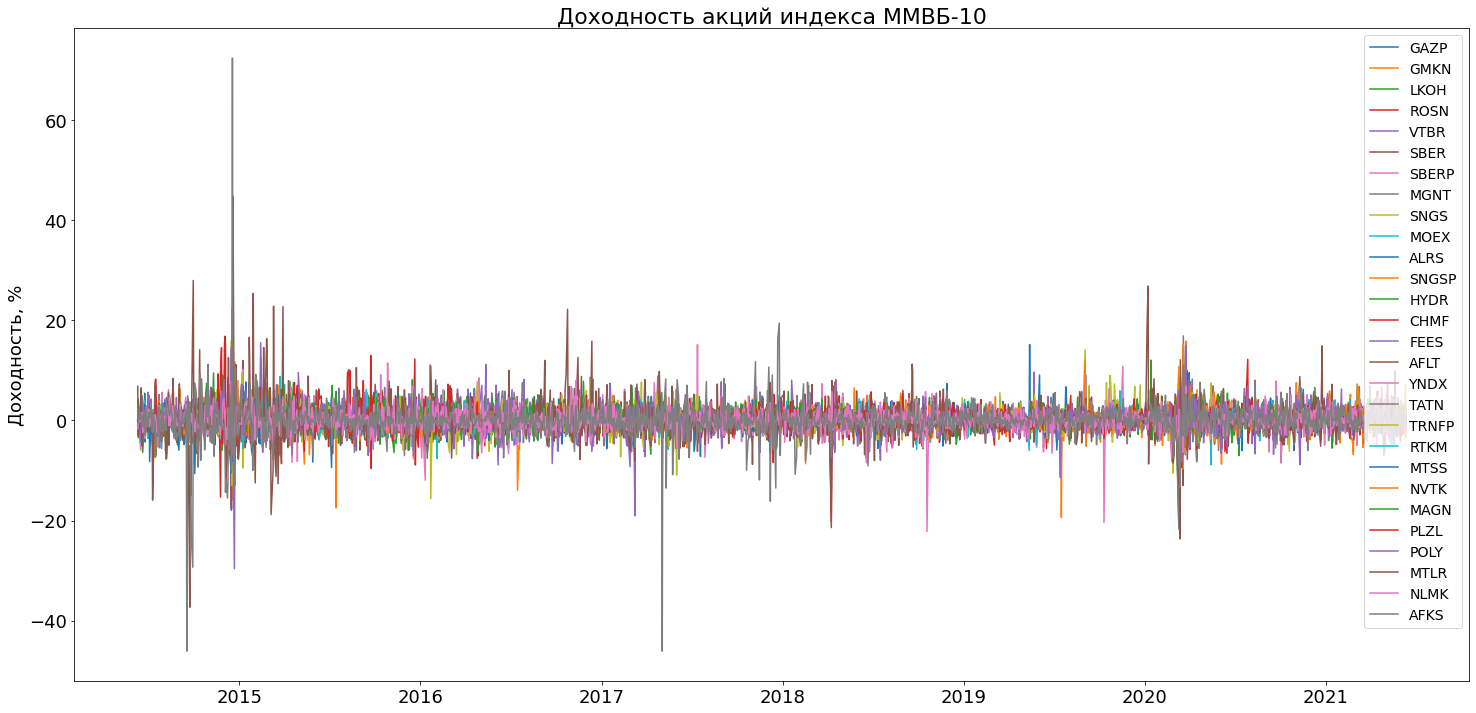

In [7]:
fig, ax = plt.subplots(figsize=(25, 12));

for ticker in rets.columns.tolist():
    ax.plot(rets.index,
             rets[ticker].values*100,
             label=str(ticker));
    
ax.legend(loc='upper right', fontsize=14);
ax.set_title('Доходность акций индекса ММВБ-10', fontsize=22);
ax.set_ylabel('Доходность, %');    

plt.savefig(image_dir/'Returns of stocks.jpg');

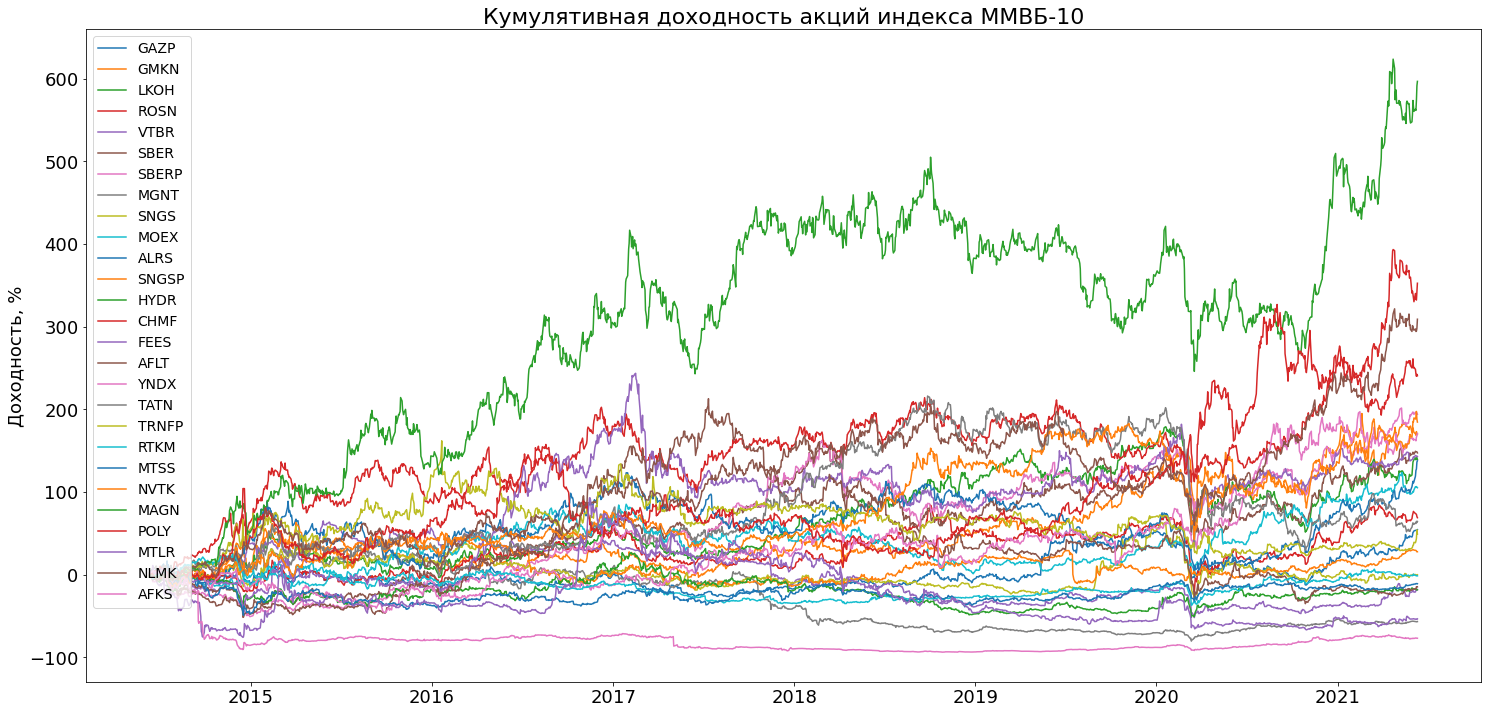

In [8]:
fig, ax = plt.subplots(figsize=(25, 12))

for ticker in rets.drop(columns=['PLZL']).columns.tolist():
    ax.plot(rets.index,
             (np.cumprod(rets[ticker].values+1)-1)*100,
             label=str(ticker));
    
ax.legend(loc='upper left', fontsize=14);
ax.set_title('Кумулятивная доходность акций индекса ММВБ-10', fontsize=22);
ax.set_ylabel('Доходность, %');    

plt.savefig(image_dir/'Cumulative returns of stocks.jpg');

На прошлом графике мы не нарисовали "Полюс Золото", поскольку его акции выросли гораздо больше всего рынка:

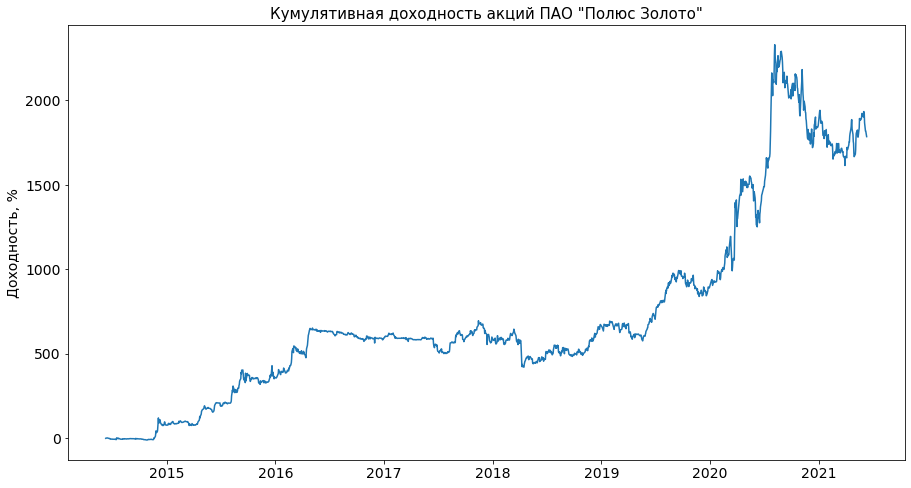

In [9]:
plt.rcParams.update({'font.size': 14});
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(rets.PLZL.index, (np.cumprod(rets.PLZL.values+1)-1)*100);

ax.set_title('Кумулятивная доходность акций ПАО "Полюс Золото"', fontsize=15);
ax.set_ylabel('Доходность, %');    

plt.savefig(image_dir/'Cumulative returns of PLZL.jpg');

Но график с кумулятивной доходностью, если честно, не очень понятный. Проще посмотреть на таблицу или столбчатый график:

C:\Users\Vladimir\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


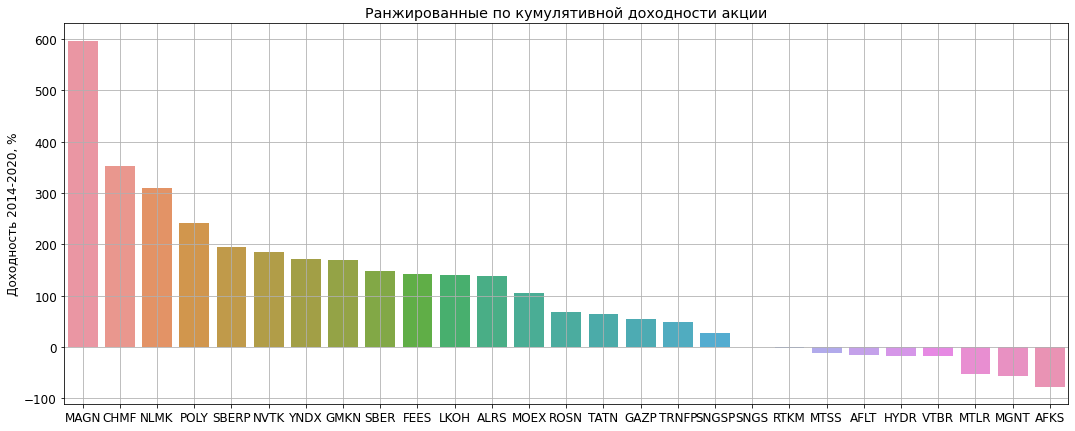

In [10]:
plt.rcParams.update({'font.size': 12});

cumulative_rets = (((rets.drop(columns=['PLZL'])+1).cumprod()-1)*100).iloc[-1, :].sort_values(ascending=False)

plt.figure(figsize=(18, 7));
plt.title('Ранжированные по кумулятивной доходности акции');
sns.barplot(cumulative_rets.index.values.tolist(), cumulative_rets.values.tolist());
plt.grid(True);
plt.ylabel('Доходность 2014-2020, %')
plt.savefig(image_dir/'Sorted cumulative returns of stocks.jpg');

Аналогично поступим со стандартными отклонениями акций:

C:\Users\Vladimir\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


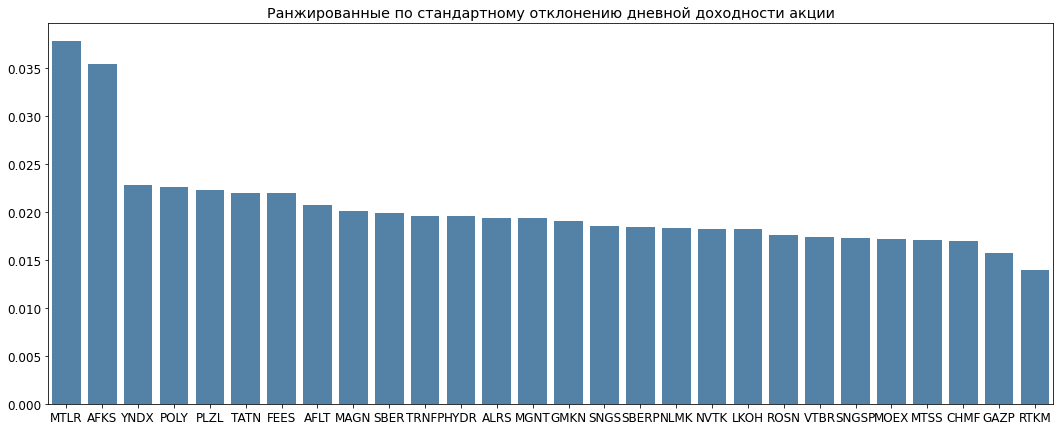

In [12]:
std_data = rets.std().sort_values(ascending=False)

plt.figure(figsize=(18, 7));
plt.title('Ранжированные по стандартному отклонению дневной доходности акции');
sns.barplot(std_data.index.values.tolist(), std_data.values.tolist(), color='steelblue');
plt.savefig(image_dir/'Sorted standard deviations of stocks.jpg');

### 8.	Выбрать индекс для расчёта исторических и скорректированных β. Привести обоснование выбора. <a class="anchor" id="choosebeta"></a>

Собственно выбор у нас невелик - на российском рынке не так много индексов. Индекс ММВБ10, от которого мы отталкивались при выборе эмитентов, не слишком рапространён. Наиболее известный индекс, который считается в определённой степени "прокси" на динамику российского рынка акций - индекс ММВБ (IMOEX). Его мы и будем использовать при расчёте беты.

Для начала хорошо бы получить данные по индексу. У нас два варианта: попробовать по API ММВБ, но может не выйти - парсер, написанный нами, предназначен для акций; или выкачать котировки закрытия из Bloomberg/Thomson Reuters.

In [18]:
from moexparser import get_historical_data

try:
    moex = get_historical_data(['IMOEX'],
                           start_date='2010-01-01',
                           end_date='2021-06-12')
except ValueError as e:
    print('Через наш парсер нельзя получить исторические данные по индексу. \n',e)

Через наш парсер нельзя получить исторические данные по индексу. 
 Тикер, который вы ввели, не торгуется в основном режиме (T+) на ММВБ.Либо вы неправильно ввели тикер, либо измените режим торгов!


Тогда получим данные из Thomson Reuters, заодно сразу выкачаем данные для ММВБ10 - они нам могут пригодиться. При загрузке данных проверил, что они совпадают с цифрами на сайте ММВБ.

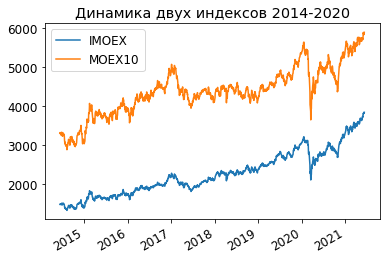

In [20]:
index_path = data_dir/'indexes.csv'
index_p = pd.read_csv(index_path,
                      header=0,
                      index_col=0,
                      parse_dates=True)
index_p.plot(title='Динамика двух индексов 2014-2020');

<AxesSubplot:title={'center':'Кумулятивная доходность индексов за аналогичный период'}>

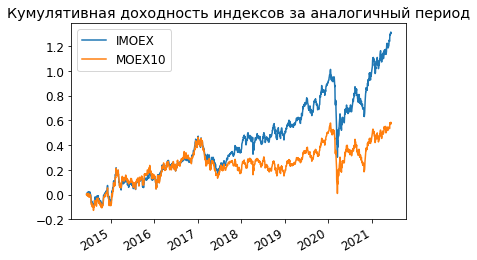

In [21]:
index_rets = np.log(1+index_p.pct_change()).iloc[1:]
((index_rets+1).cumprod()-1).plot(title='Кумулятивная доходность индексов за аналогичный период')

То ли у индекса ММВБ10 методика отбора эмитентов неудачная, то ли дело действительно в более широком наборе эмитентов в ММВБ (вот она, родимая диверсификация) и в том, что настоящий value может быть спрятан в акциях второго эшелона. При этом ММВБ ещё и сопоставим по волатильности:

Соотношение волатильности ММВБ к ММВБ10 составляет 0.9691169943514203


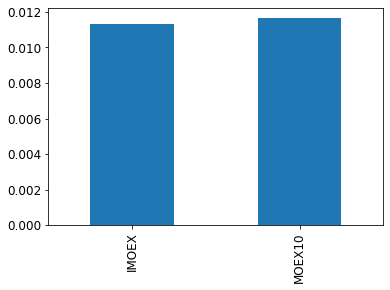

In [24]:
print(f"Соотношение волатильности ММВБ к ММВБ10 составляет {index_rets.IMOEX.std()/index_rets.MOEX10.std()}")
index_rets.std().plot(kind='bar');

Возможно, вышло так, что в выгрузке по API Мосбиржи есть даты, которых нет в выгрузке из Thomson Reuters, и наоборот. Нам хотелось бы этого избежать, ведь мы по данным индекса будем рассчитывать беты для отдельных акций.

In [6]:
indexes = pd.merge(prices.GAZP, index_p, 
                   how='left',
                   right_index=True,
                   left_index=True)
indexes.drop(columns=['GAZP'], inplace=True)
indexes.fillna(method='ffill', inplace=True)
indexes.to_csv(data_dir/'clean_index_prices.csv')

indexes = np.log(1+indexes.pct_change()).iloc[1:, ]
indexes.to_csv(data_dir/'clean_index_rets.csv')

NameError: name 'index_p' is not defined

### 9.	Рассчитать ковариационную матрицу для отобранных акций на основе исторических β (historical betas), которые оцениваются согласно рыночной модели (market model). <a class="anchor" id="betacovmat"></a>

Теперь, когда мы сохранили данные в нормальном виде, можно их заново прочитать (чтобы в дальнейшем при моделировании не заморачиваться каждый раз с запуском ячеек выше для предобработки котировок индекса).

In [7]:
indexes = pd.read_csv(data_dir/'clean_index_rets.csv',
                      header=0,
                      index_col=0,
                      parse_dates=True)
indexes.head(5)

,IMOEX,MOEX10
TRADEDATE,,
2014-06-10,0.003642,-0.000703
2014-06-11,0.006932,0.007947
2014-06-16,-0.004841,-0.011647
2014-06-17,-0.005067,-0.007176
2014-06-18,0.005301,0.006549


Для начала посмотрим на корреляцию между индексами и теми эмитентами, которые есть в выборке. Очевидно, что это лишь грубая оценка и корреляции существенно меняются во времени.

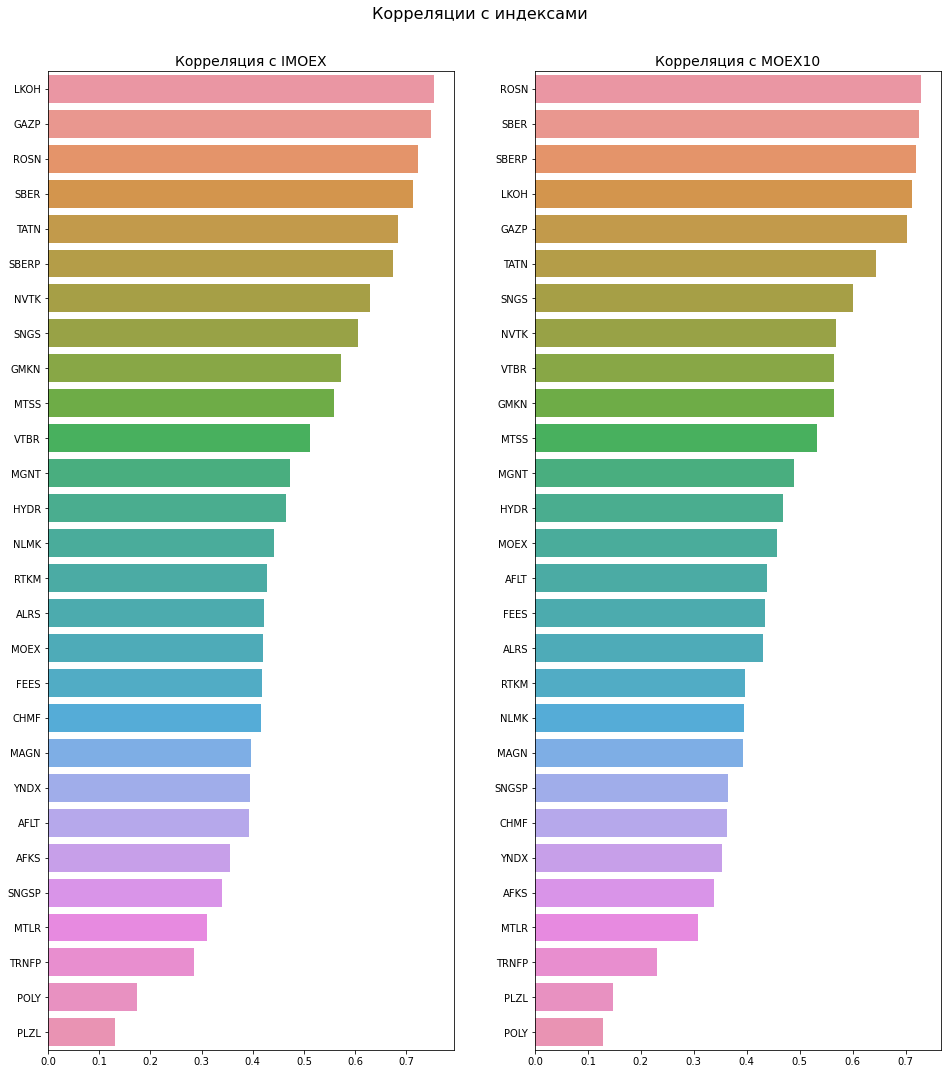

In [9]:
imoex_corr = rets.corrwith(indexes.IMOEX).sort_values(ascending=False)
moex10_corr = rets.corrwith(indexes.MOEX10).sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 18))

sns.barplot(y=imoex_corr.index.values.tolist(),
            x=imoex_corr.values.tolist(),
            ax=ax1);
ax1.set_title('Корреляция с IMOEX', fontsize=14);

sns.barplot(y=moex10_corr.index.values.tolist(),
            x=moex10_corr.values.tolist(),
            ax=ax2);
ax2.set_title('Корреляция с MOEX10', fontsize=14);

fig.suptitle('Корреляции с индексами', fontsize=16, y=0.93);
plt.savefig(image_dir/'Correlations with index.jpg', dpi=600, bbox_inches='tight');

В общем-то, ничего особенно удивительного мы не увидели. 
1. Наиболее связаны с индексом нефтяники и газовики, поскольку они в среднем исторически имеют наибольшую капитализацию и ликвидность на ММВБ, а значит, и наибольшие веса в индексе ММВБ - именно он интересует нас в первую очередь. 
2. Металлурги (кроме золотодобытчиков) находятся где-то посередине и по капитализации с ликвидностью, и по весам в индексе.
3. Золотодобытчики находятся в хвосте, поскольку золото - традиционно защитный актив, и котировки компаний, связанных с ним, должны двигаться в направлении, противоположном всему остальному рынку; но поскольку у "Полюс Золота" и "Полиметалла" неплохая капитализация и они с приличными весами входят в индекс ММВБ, корреляция мала и положительна.

В общем и целом, корреляция пропорциональна весам эмитентов в индексе ММВБ.

Что мы хотим? 
* Оценивать бету по выборке и возвращать оценённые значения y, а также саму бету
  - иметь возможность подставлять в уравнение константу или нет
* Иметь возможность параллельной оценки бет
* Оценивать ковариационную матрицу на основе очищенной доходности
* В идеале, выбрать оптимальный период, на котором надо оценивать и усреднять беты. 
 - Для оценки нужная целевая метрика ошибки. Baseline - MSE. Возможно, стоит над другой подумать? (MSE слишком большой вес придаёт выбросам, а они в выборке есть в период кризиса). На Kaggle вроде были другие метрики на соревнованиях, связанных с трейдингом?



In [29]:
from sklearn.linear_model import LinearRegression

X = indexes.IMOEX.values.reshape(-1, 1)
y = rets.GAZP.values.reshape(-1, 1)

In [30]:
testmodel = LinearRegression().fit(X, y)
testmodel.coef_

array([[1.04136582]])

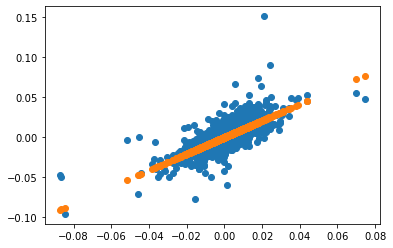

In [31]:
plt.scatter(X.ravel(), y.ravel());
plt.scatter(X, testmodel.predict(X));

In [32]:
X = np.column_stack([np.ones(shape=(indexes.shape[0], 1)),
                     indexes.IMOEX.values.reshape(-1, 1)])

In [33]:
X

array([[ 1.        ,  0.00364223],
       [ 1.        ,  0.00693187],
       [ 1.        , -0.00484123],
       ...,
       [ 1.        ,  0.00549738],
       [ 1.        , -0.00405946],
       [ 1.        ,  0.00360401]])

In [40]:
testmodel = LinearRegression().fit(X, y)
testmodel.coef_

array([[0.        , 1.04136582]])

<function matplotlib.pyplot.scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=<deprecated parameter>, edgecolors=None, *, plotnonfinite=False, data=None, **kwargs)>

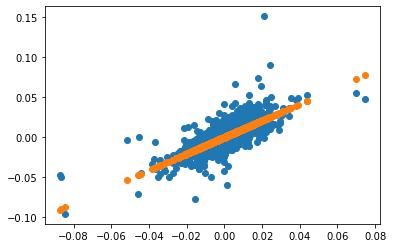

In [48]:
plt.scatter(indexes.IMOEX.values,
rets.GAZP.values);
plt.scatter(indexes.IMOEX.values.tolist(),
            (testmodel.coef_@X.T).T.values.tolist());
plt.scatter

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


class Beta:
    def __init__(self, asset, index, constant=False):
        """
        constant: whether to include constant in market model equation
        """
        self.asset = asset
        self.index = index
        self.constant = constant
        self.alpha = None
        self.beta = None
        self.coef = None
        self.fitted_values = None

    def fit(self):

        X = self.index.values.reshape(-1, 1)
        # если хотим добавить константу в уравнение, добавим единичный столбец к X
        if self.constant:
            X = np.column_stack([np.ones(shape=(self.index.shape[0], 1)),
                                 self.index.values.reshape(-1, 1)])

        model = LinearRegression()
        model.fit(X, self.asset.values)
        
        # сохраним метрики качества и коэффиценты
        self.coef = model.coef_
        self.R2 = r2_score(self.asset.values, model.predict(X))
        self.RMSE = mean_squared_error(self.asset.values, model.predict(X))**(1/2)

        # сохраним в отдельные атрибуты коэффициенты
        if self.constant:
            self.alpha = model.coef_.ravel()[0]
            self.beta = model.coef_.ravel()[1]
        self.beta = model.coef_.ravel()[0]

        # сохраним оценки y_hat
        self.fitted_values = pd.Series(data=model.predict(X),
                                       index=self.asset.index,
                                       name=self.asset.name)

    # на всякий случай, вдруг понадобится именно прогноз
    # надо пофиксить, метод прописан неверно
    def predict(self, X):
        return (testmodel.coef_@X.T).T.rename(self.asset.name)

In [9]:
from multiprocessing import cpu_count, Pool
from itertools import product, repeat
# функцию-обёртку пришлось загрузить в отдельный модуль
# если вставить её в ячейку, Питон отказывается с ней работать
from parallelbeta import ContainerFun
from datetime import datetime


class AverageBeta:

    def __init__(self, asset, index, agg_period, window,
                 constant=False, parallel=False):
        """ 
        agg_period: how many daily observations to use to calculate mean beta
        window: how many observations to use in train sample
        parallel: whether to calculate in parallel
        Recommended parallel computation for agg_period >= 60 (90?)
        """
        if asset.shape[0]-1-agg_period-window < 0:
            raise ValueError(f""" Размер тренировочной выборки: {window}.
                                  Самый большой лаг: {agg_period}.
                                  В выборке {asset.shape[0]} наблюдений.
                                  Для оценки модели {agg_period} периодов назад не хватает данных.
                                  Измените размер тренировочной выборки или глубину лага.""")

        self.agg_period = agg_period
        self.window = window
        self.asset = asset
        self.index = index
        self.constant = constant
        self.parallel = parallel
        # save all coefficient estimates
        self.alphas = dict()
        self.betas = self.alphas.copy()
        self.R2s = self.alphas.copy()
        self.errors = self.alphas.copy()

    def fit(self):
        """ Calculates betas in parallel"""
        # нагенерим индексы для разбиения
        n_obs = self.asset.shape[0]
        group_list = [list(range(n_obs-1-i-self.window,
                                 n_obs-1-i))
                      for i in list(range(self.agg_period))]
        # нагенерим по ним подвыборки для регрессий - это быстро, я проверял
        splits = zip([self.asset.iloc[y] for y in group_list],  # assets
                     [self.index.iloc[y] for y in group_list],  # indexes
                     repeat(self.constant))  # constant

        # распараллелим оценку регрессий
        if self.parallel:
            with Pool() as p:
                models = list(p.starmap(ContainerFun, splits))
            #executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
            # tasks = (delayed(containerfun)(split['asset'], split['index'])
            #         for split in splits)
            #models = executor(tasks)
            #models = [x for x in models]
            
        # если регрессий немного - 30, 60 - быстрее посчитать без распараллеливания
        else:
            models = []
            for i in range(self.agg_period):
                
                # оценим модель
                start = self.asset.shape[0]-1-i-self.window
                stop = self.asset.shape[0]-1-i
                
                data = self.asset.iloc[start:stop]
                index = self.index.iloc[start:stop]
                model = Beta(asset=data,
                             index=index,
                             constant=self.constant)
                model.fit()
                models.append(model)

        # надо из каждой модели вытащить её параметры
        for model in models:
            attr_dict = model.__dict__
            # номер модели - последняя дата, которая есть в тренировочной выборке модели
            i = attr_dict['asset'].index[-1].date().strftime('%Y-%m-%d')

            # сохраним характеристики каждого уравнения
            self.betas[i] = attr_dict['beta']
            self.alphas[i] = attr_dict['alpha']
            self.R2s[i] = attr_dict['R2']
            self.errors[i] = attr_dict['RMSE']

        # ради чего все усилия
        self.average_beta = pd.Series(self.betas).mean()
        self.median_beta = pd.Series(self.betas).median()

Проверим правильность расчётов на реальных данных.

In [10]:
import statsmodels.api as sm

In [11]:
test_rets = rets[['SBER', 'GAZP', 'VTBR']]

In [12]:
%%time
testabeta = AverageBeta(test_rets.SBER, indexes.IMOEX, agg_period=126, window=126, parallel=True)
testabeta.fit()

Wall time: 3.6 s


In [13]:
%%time
testabeta = AverageBeta(test_rets.SBER, indexes.IMOEX, agg_period=126, window=126, parallel=False)
testabeta.fit()

Wall time: 193 ms


Забавно. То есть даже на достаточно большой глубине выборки, когда надо посчитать 126 линейный регрессий, быстрее работает оценка безо всякого распараллеливания - по сути, ведь нужно сделать только 126 матричных умножений.

In [27]:
class BetaCov:
    """
    Returns covariance matrix of returns fitted with market model
    and characteristics of market model regressions
    """

    def __init__(self, data: pd.DataFrame, index):
        """
        data: asset returns
        index: index to estimate market model
        constant: whether to include constant in market model equation
        """
        self.data = data
        self.index = index
        # сохраним оценки доходностей, полученные из market model
        self.fitted_data = pd.DataFrame(data=None,
                                        columns=self.data.columns)

        self.betas = pd.Series(data=None,
                               index=self.data.columns)
        self.R2 = self.betas.copy()
        self.RMSE = self.betas.copy()
        self.vcov = None

    def fit(self, agg_period=None, window=None, method='mean',
            parallel=False, constant=False):

        self.parallel = parallel
        self.constant = constant
        
        # если мы усредняем бету
        if agg_period:

            # изменим тип атррибута на DataFrame
            self.betas = pd.DataFrame(data=None,
                                      columns=self.data.columns)
            self.R2 = self.betas.copy()
            self.RMSE = self.betas.copy()
            # сохраним параметры усреднения
            self.agg_period = agg_period
            self.window = window
            self.method = method
            self.average_betas, self.median_betas = dict(), dict()

            # оценим среднюю бету для каждого актива
            for ticker in self.data.columns:

                beta = AverageBeta(asset=self.data[ticker],
                                   index=self.index,
                                   constant=self.constant,
                                   agg_period=self.agg_period,
                                   window=self.window,
                                   parallel=self.parallel)
                beta.fit()
                self.betas[ticker] = pd.Series(beta.betas)
                self.R2[ticker] = pd.Series(beta.R2s)
                self.RMSE[ticker] = pd.Series(beta.errors)
                self.average_betas[ticker], self.median_betas[ticker] = beta.average_beta, beta.median_beta
            
            # оценим ковариационную матрицу
            # берём среднюю бету из всех оценённых бет для каждого актива
            if self.method =='mean':
                self.vcov = (self.data * pd.Series(self.average_betas)).cov()
            # берём медианную бету из всех оценённых бет для каждого актива
            elif self.method =='median'    :
                self.vcov = (self.data * pd.Series(self.median_betas)).cov()

        else:
            # если мы не усредняем бету для каждого актива 
            # то тогда просто считаем одну бету по всей выборке для каждого актива
            # и строим ковариационную матрицу по оценкам доходности с помощью этих бет
            for ticker in self.data.columns:
                beta = Beta(asset=self.data[ticker],
                            index=self.index,
                            constant=self.constant)
                beta.fit()
                self.fitted_data[ticker] = beta.fitted_values
                # сохраним характеристики уравнения
                self.betas[ticker], self.R2[ticker], self.RMSE[ticker] = beta.beta, beta.R2, beta.RMSE
                
            # оценим ковариационную матрицу
            self.vcov = self.fitted_data.cov()

To do:
1. проверить, что ковариационная матрица выходит верная, на трёх активах - проверил
2. класс AverageBeta - параллельный фиттинг кучи бет для одного актива - сделано
3. **Сделать оценку ковариационной матрицы по средней бете - с расчётом самих бет всё окей, вроде всё правильно считается**

Посчитаем ковариационную матрицу по одной оценке беты.

In [25]:
# посчитаем вручную ковариационную матрицу для проверки нашего класса
sberlm = sm.OLS(test_rets.SBER, indexes.IMOEX)
vtblm = sm.OLS(test_rets.VTBR, indexes.IMOEX)
gazplm = sm.OLS(test_rets.GAZP, indexes.IMOEX)

sberres = sberlm.fit()
vtbres = vtblm.fit()
gazpres = gazplm.fit()

fitted = pd.DataFrame({'SBER': sberres.fittedvalues,
                       'GAZP': gazpres.fittedvalues,
                       'VTBR': vtbres.fittedvalues})


print('Тестовая ковариационная матрица (посчитана вручную): ')
fitted.cov()

# тот же самый расчёт с помощью нашего класса
testbeta = BetaCov(test_rets, indexes.IMOEX)
testbeta.fit()
print('Тестовая ковариационная матрица с помощью нашего класса: ')
testbeta.vcov

Тестовая ковариационная матрица (посчитана вручную): 


,SBER,GAZP,VTBR
SBER,0.000201,0.000167,0.000126
GAZP,0.000167,0.000138,0.000104
VTBR,0.000126,0.000104,0.000079


Тестовая ковариационная матрица с помощью нашего класса: 


<ipython-input-24-937d39e0bfc9>:19: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.betas = pd.Series(data=None,


,SBER,GAZP,VTBR
SBER,0.000201,0.000167,0.000126
GAZP,0.000167,0.000138,0.000104
VTBR,0.000126,0.000104,0.000079


In [29]:
%%time
testbeta = BetaCov(test_rets, indexes.IMOEX)
testbeta.fit(agg_period=900, window=126, method='mean')
testbeta.vcov

<ipython-input-27-e6bdd1c2ea8e>:19: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.betas = pd.Series(data=None,


Wall time: 4.58 s


,SBER,GAZP,VTBR
SBER,0.000683,0.000259,0.000171
GAZP,0.000259,0.000370,0.000105
VTBR,0.000171,0.000105,0.000208


In [18]:
testbeta.median_betas

{'SBER': 1.243599970756796,
 'GAZP': 1.0536479342394667,
 'VTBR': 0.8500085847906733}

In [19]:
testbeta.average_betas

{'SBER': 1.3122153071161833,
 'GAZP': 1.2231580977450724,
 'VTBR': 0.8314497964438333}

In [20]:
testbeta.data.head()

,SBER,GAZP,VTBR
TRADEDATE,,,
2014-06-10,0.001124,0.002421,-0.006574
2014-06-11,0.000112,0.011334,-0.000426
2014-06-16,-0.047751,-0.008230,-0.011776
2014-06-17,-0.012452,-0.002966,0.007937
2014-06-18,-0.000358,0.001587,-0.018329


In [23]:
(testbeta.data * pd.Series(testbeta.average_betas)).cov()

,SBER,GAZP,VTBR
SBER,0.000683,0.000259,0.000171
GAZP,0.000259,0.000370,0.000105
VTBR,0.000171,0.000105,0.000208


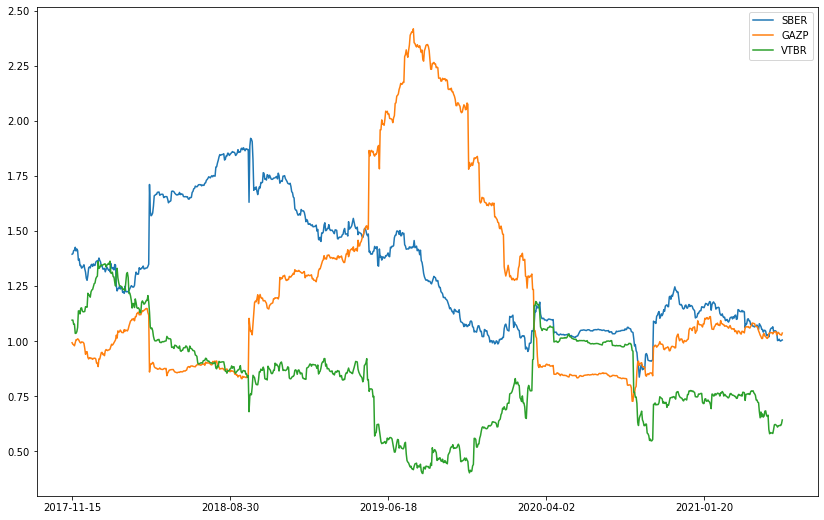

In [98]:
testbeta.betas.sort_index(ascending=True).plot(figsize=(14, 9));

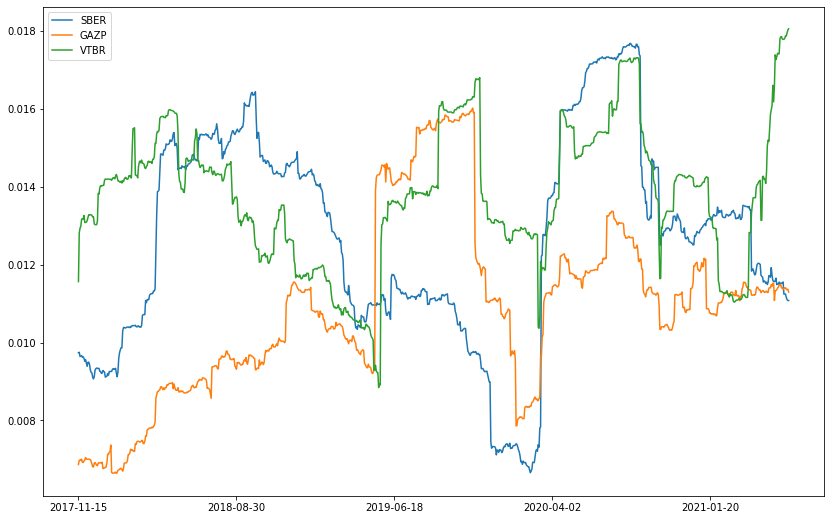

In [99]:
testbeta.RMSE.sort_index(ascending=True).plot(figsize=(14, 9));

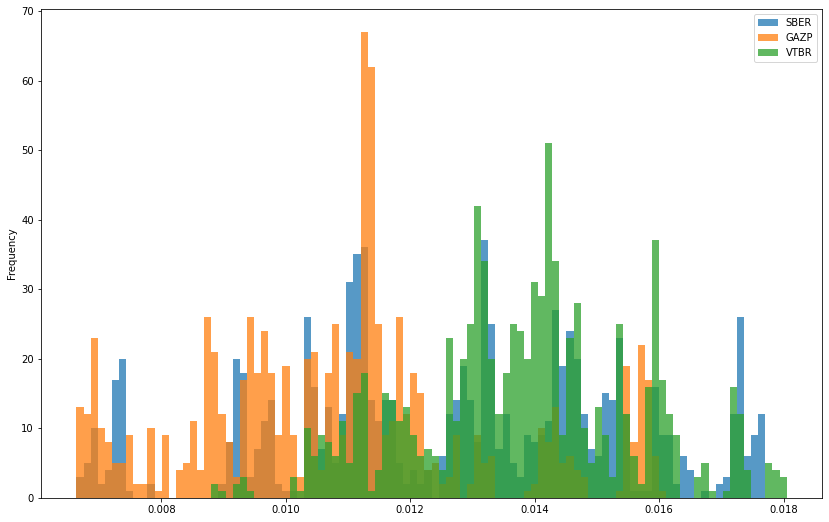

In [93]:
testbeta.RMSE.sort_index(ascending=True).plot(kind='hist', bins=100, alpha=0.75, figsize=(14, 9));

### 10.	Построить границу эффективных портфелей на основе полученной в п. 8 ковариационной матрицы и проанализировать динамику её изменения.<a class="anchor" id="betacovmat_results"></a>